In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import heapq



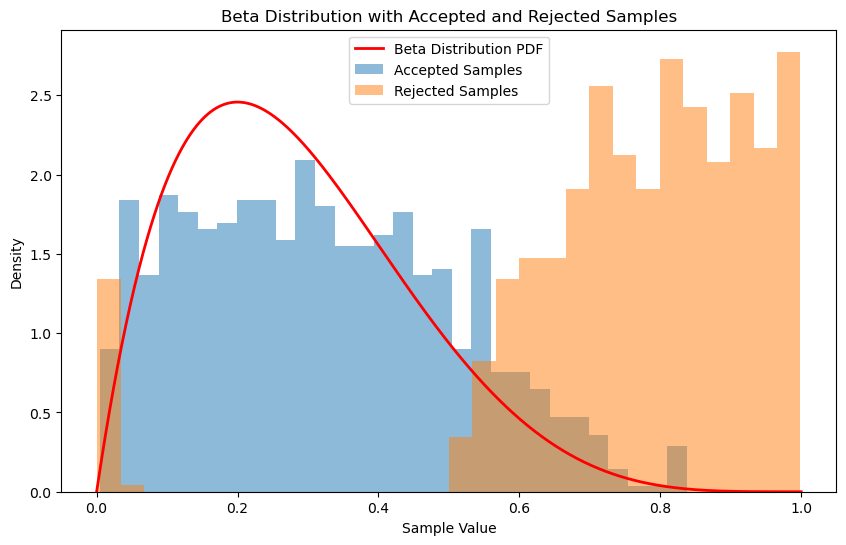

In [16]:
# question a
def beta_acceptance_rejection(alpha, beta, n_samples):
    target_dist = stats.beta(alpha, beta)
    proposal_dist = stats.uniform(0, 1)

    samples = []
    rejected = []
    while len(samples) < n_samples:
        x = proposal_dist.rvs()
        acceptance_prob = target_dist.pdf(x) / proposal_dist.pdf(x)

        if np.random.rand() < acceptance_prob:
            samples.append(x)
        else:
            rejected.append(x)
    
    return samples, rejected

# Generate samples
alpha = 2
beta = 5
n_samples = 1000
accepted, rejected = beta_acceptance_rejection(alpha, beta, n_samples)


# Plotting the distribution function along with accepted and rejected samples
x = np.linspace(0, 1, 1000)
y = stats.beta.pdf(x, alpha, beta)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r-', lw=2, label='Beta Distribution PDF')
plt.hist(accepted, bins=30, alpha=0.5, density=True, label='Accepted Samples')
plt.hist(rejected, bins=30, alpha=0.5, density=True, label='Rejected Samples')
plt.title('Beta Distribution with Accepted and Rejected Samples')
plt.xlabel('Sample Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [17]:
# question b
def lamp_on_off(matrix):
    """
    Check if there is a conductive path from the first to the last column of the matrix,
    considering up, down, and right movements.

    :param matrix: A 2D list representing the circuit with 1s and 0s.
    :return: 'On' if there is a path, otherwise 'Off'.
    """
    def is_valid(node):
        x, y = node
        return 0 <= x < len(matrix) and 0 <= y < len(matrix[0]) and matrix[x][y] == 1

    def get_neighbors(node):
        x, y = node
        directions = [(0, 1), (1, 0), (-1, 0)]  # Right, Down, Up
        neighbors = [(x + dx, y + dy) for dx, dy in directions]
        return [n for n in neighbors if is_valid(n)]

    def dijkstra(start):
        end_column = len(matrix[0]) - 1
        heap = [(0, start)]  # (cost, node)
        visited = set()
        while heap:
            cost, node = heapq.heappop(heap)
            if node in visited:
                continue
            visited.add(node)
            if node[1] == end_column:  # Check if we've reached the last column
                return True
            for neighbor in get_neighbors(node):
                if neighbor not in visited:
                    heapq.heappush(heap, (cost + 1, neighbor))
        return False

    # Check for a path from each conductive position in the first column
    for x in range(len(matrix)):
        if matrix[x][0] == 1:  # Start only from conductive cells in the first column
            start = (x, 0)
            if dijkstra(start):
                return 'On'
    return 'Off'



Naive Estimator: Mean = 0.06225133752660384, Variance = 0.019468392758359286, MSE = 0.019468392758359286
Conditional Estimator: Mean = 0.06175999999999999, Variance = 0.013831416685714283, MSE = 0.013831416685714283


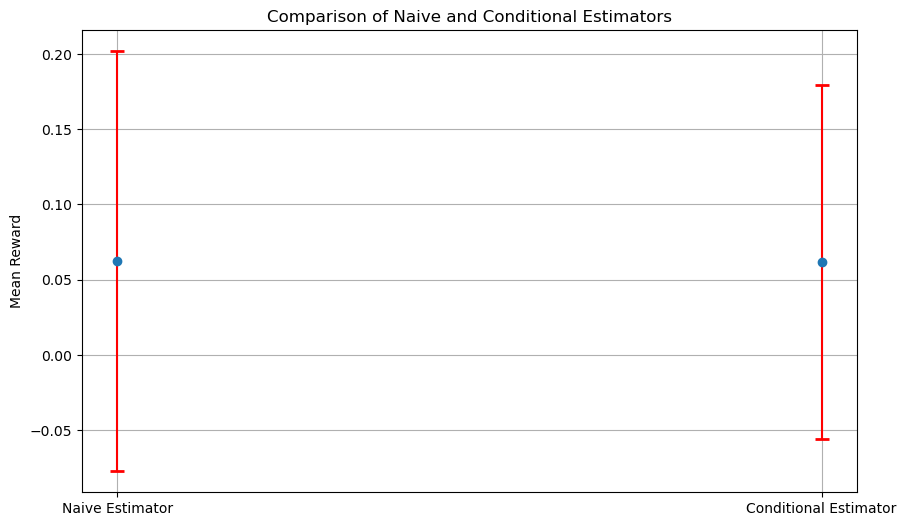

In [18]:
# question c
import numpy as np
import random
import matplotlib.pyplot as plt


# Simulation parameters
matrix_size = (5, 6)
alpha, beta = 2, 5
num_steps = 100000  # Number of steps in the simulation

def simulate_naive_estimator(num_steps, matrix_size, alpha, beta):
    matrix = np.zeros(matrix_size, dtype=int)
    rewards = []
    lamp_on_count = 0
    for _ in range(num_steps):
        # Randomly choose a switch to reset
        x, y = random.randint(0, matrix_size[0] - 1), random.randint(0, matrix_size[1] - 1)
        matrix[x][y] = 1 - matrix[x][y]
        if lamp_on_off(matrix) == 'On':
            lamp_on_count += 1
            reward = np.random.beta(alpha, beta)
        else:
            reward = 0
        rewards.append(reward)
    lamp_on_probability = lamp_on_count / num_steps
    return rewards, lamp_on_probability

def simulate_conditional_estimator(num_steps, lamp_on_probability, alpha, beta):
    expected_reward_on = alpha / (alpha + beta)
    conditional_rewards = [expected_reward_on if random.random() < lamp_on_probability else 0 for _ in range(num_steps)]
    return conditional_rewards

# Run naive estimator simulation
naive_rewards, lamp_on_probability = simulate_naive_estimator(num_steps, matrix_size, alpha, beta)
# Run conditional estimator simulation with the same lamp on probability
conditional_rewards = simulate_conditional_estimator(num_steps, lamp_on_probability, alpha, beta)

# Calculating statistics for naive estimator
naive_mean = np.mean(naive_rewards)
naive_variance = np.var(naive_rewards)
naive_mse = np.mean((np.array(naive_rewards) - naive_mean)**2)

# Calculating statistics for conditional estimator
conditional_mean = np.mean(conditional_rewards)
conditional_variance = np.var(conditional_rewards)
conditional_mse = np.mean((np.array(conditional_rewards) - conditional_mean)**2)

# Printing results
print(f"Naive Estimator: Mean = {naive_mean}, Variance = {naive_variance}, MSE = {naive_mse}")
print(f"Conditional Estimator: Mean = {conditional_mean}, Variance = {conditional_variance}, MSE = {conditional_mse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(x=['Naive Estimator', 'Conditional Estimator'], 
             y=[naive_mean, conditional_mean], 
             yerr=[np.sqrt(naive_variance), np.sqrt(conditional_variance)], 
             fmt='o', capsize=5, capthick=2, ecolor='red')
plt.title('Comparison of Naive and Conditional Estimators')
plt.ylabel('Mean Reward')
plt.grid(True)
plt.show()


---

**Naive Estimator**  
The Naive Estimator directly simulates the reward in each time step. It randomly generates a reward based on the distribution of X when the lamp is on, and a reward of 0 when the lamp is off. This direct simulation introduces variability inherent to the random nature of the reward distribution, leading to a higher variance.

**Conditional Estimator**  
The Conditional Estimator calculates the expected reward based on the probability of the lamp being on. It uses the expected value of the reward distribution (X) when the lamp is on, multiplied by the probability of the lamp being on. Since this method does not involve direct random sampling from the reward distribution in each step, it naturally results in lower variability, hence a lower variance.

**Conclusion**  
While both estimators provide insights into the expected reward, the Conditional Estimator is generally more reliable due to its lower variance. This reduced variability makes it better suited for consistent prediction of rewards, particularly in applications where stability and predictability are crucial.

---


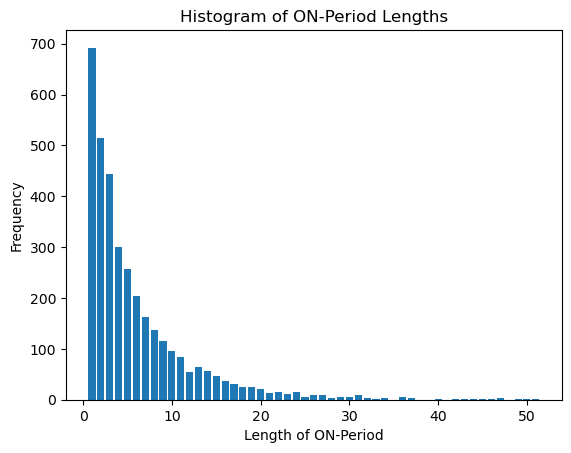

In [19]:
# question d
def simulate_on_periods(num_steps, matrix_size):
    matrix = np.zeros(matrix_size, dtype=int)
    on_periods = []
    on_period_length = 0
    lamp_was_on = False

    for _ in range(num_steps):
        # Randomly choose a switch to reset
        x, y = random.randint(0, matrix_size[0] - 1), random.randint(0, matrix_size[1] - 1)
        matrix[x][y] = 1 - matrix[x][y]

        if lamp_on_off(matrix) == 'On':
            if not lamp_was_on:
                # Lamp just turned on, start a new ON-period
                on_period_length = 1
                lamp_was_on = True
            else:
                # Lamp continues to be on, increase ON-period length
                on_period_length += 1
        else:
            if lamp_was_on:
                # Lamp just turned off, end the current ON-period
                on_periods.append(on_period_length)
                lamp_was_on = False

    return on_periods

# Simulate the ON-periods
num_steps = 100000  #
matrix_size = (5, 6)  
on_periods = simulate_on_periods(num_steps, matrix_size)

# Plotting the histogram of ON-period lengths
plt.hist(on_periods, bins=range(1, max(on_periods)+1), align='left', rwidth=0.8)
plt.title('Histogram of ON-Period Lengths')
plt.xlabel('Length of ON-Period')
plt.ylabel('Frequency')
plt.show()


In [8]:
import numpy as np
from scipy import stats

def calculate_estimates(on_periods, batch_size):
    if batch_size:
        batch_means_EA = [np.mean(on_periods[i:i + batch_size]) for i in range(0, len(on_periods), batch_size)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods[i:i + batch_size]]) for i in range(0, len(on_periods), batch_size)]
    else:
        batch_means_EA = [np.mean(on_periods)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods])]

    EA_estimate = np.mean(batch_means_EA)
    Prob_estimate = np.mean(batch_means_Prob)

    variance_EA = np.var(batch_means_EA, ddof=1) if batch_size else np.var(on_periods, ddof=1)
    variance_Prob = np.var(batch_means_Prob, ddof=1) if batch_size else np.var([length > 20 for length in on_periods], ddof=1)

    ci_EA = stats.norm.interval(0.95, loc=EA_estimate, scale=np.sqrt(variance_EA / len(batch_means_EA)))
    ci_Prob = stats.norm.interval(0.95, loc=Prob_estimate, scale=np.sqrt(variance_Prob / len(batch_means_Prob)))

    return EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob

# Parameters for the simulation
num_steps = 300000
matrix_size = (5, 6)
batch_sizes = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900, 1000, 2000, 3000, 4000, 5000,6000,7000,8000,9000,10000] 

# Run simulation and gather data (assuming simulate_on_periods is defined)
on_periods = simulate_on_periods(num_steps, matrix_size)

# Analyze results with different batch sizes
for batch_size in batch_sizes:
    EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob = calculate_estimates(on_periods, batch_size)
    print(f"Batch Size: {batch_size if batch_size else 'No Batching'}")
    print(f"Estimated E[A]: {EA_estimate} with 95% CI: {ci_EA}")
    print(f"Estimated Prob[A > 20]: {Prob_estimate} with 95% CI: {ci_Prob}")
    print(f"Variance for E[A]: {variance_EA}, Variance for Prob[A > 20]: {variance_Prob}\n")


Batch Size: 10
Estimated E[A]: 5.961606319947334 with 95% CI: (5.841985059471816, 6.081227580422852)
Estimated Prob[A > 20]: 0.0367741935483871 with 95% CI: (0.033268540468486464, 0.04027984662828774)
Variance for E[A]: 4.041571858202359, Variance for Prob[A > 20]: 0.003471134388763243

Batch Size: 20
Estimated E[A]: 5.959010786635096 with 95% CI: (5.836278409723908, 6.0817431635462835)
Estimated Prob[A > 20]: 0.036740331491712706 with 95% CI: (0.03319214457563863, 0.040288518407786786)
Variance for E[A]: 2.1292268681340554, Variance for Prob[A > 20]: 0.0017795763592995044

Batch Size: 30
Estimated E[A]: 5.960459321850287 with 95% CI: (5.8392094618864725, 6.081709181814102)
Estimated Prob[A > 20]: 0.036740331491712706 with 95% CI: (0.03313841585102425, 0.040342247132401164)
Variance for E[A]: 1.3853990320710725, Variance for Prob[A > 20]: 0.001222586125097565

Batch Size: 40
Estimated E[A]: 5.953834033613445 with 95% CI: (5.832961083779742, 6.074706983447148)
Estimated Prob[A > 20]: 0.

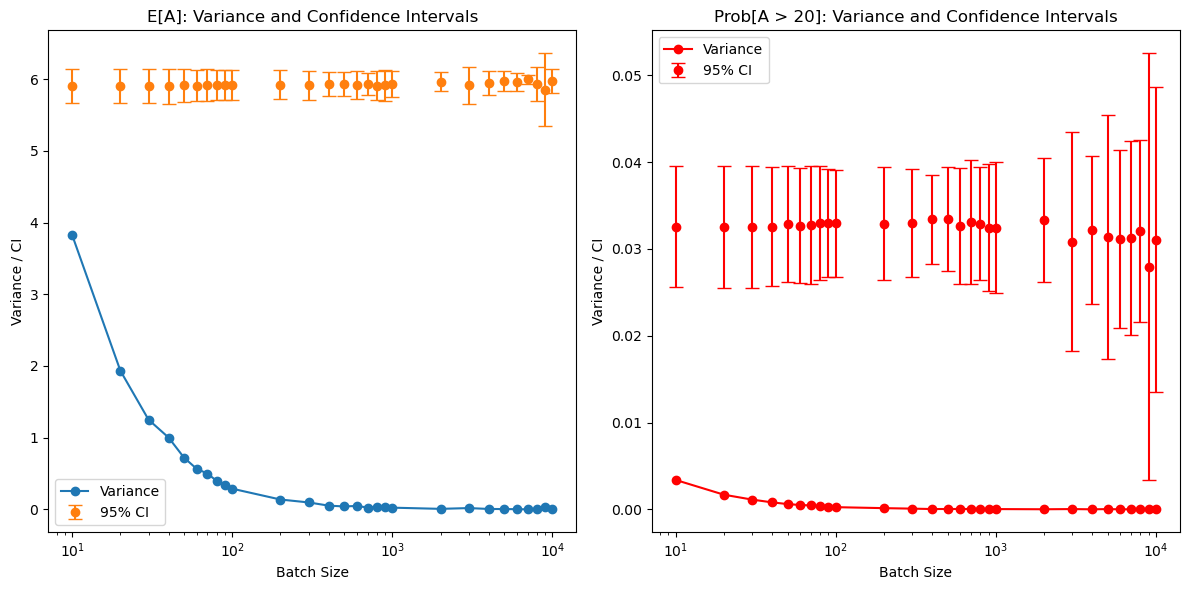

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_estimates(on_periods, batch_size):
    if batch_size:
        batch_means_EA = [np.mean(on_periods[i:i + batch_size]) for i in range(0, len(on_periods), batch_size)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods[i:i + batch_size]]) for i in range(0, len(on_periods), batch_size)]
    else:
        batch_means_EA = [np.mean(on_periods)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods])]

    EA_estimate = np.mean(batch_means_EA)
    Prob_estimate = np.mean(batch_means_Prob)

    variance_EA = np.var(batch_means_EA, ddof=1) if batch_size else np.var(on_periods, ddof=1)
    variance_Prob = np.var(batch_means_Prob, ddof=1) if batch_size else np.var([length > 20 for length in on_periods], ddof=1)

    ci_EA = stats.norm.interval(0.95, loc=EA_estimate, scale=np.sqrt(variance_EA / len(batch_means_EA)))
    ci_Prob = stats.norm.interval(0.95, loc=Prob_estimate, scale=np.sqrt(variance_Prob / len(batch_means_Prob)))

    return EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob
# Parameters for the simulation
num_steps = 300000
matrix_size = (5, 6)
batch_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Run simulation and gather data
on_periods = simulate_on_periods(num_steps, matrix_size)

# Data for plotting
batch_sizes_plot = []
variances_EA = []
variances_Prob = []
ci_EA_values = []
ci_Prob_values = []

# Analyze results with different batch sizes
for batch_size in batch_sizes:
    EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob = calculate_estimates(on_periods, batch_size)
    batch_sizes_plot.append(batch_size)
    variances_EA.append(variance_EA)
    variances_Prob.append(variance_Prob)
    ci_EA_values.append(ci_EA)
    ci_Prob_values.append(ci_Prob)

# Plotting for E[A]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(batch_sizes_plot, variances_EA, marker='o', label='Variance')
plt.errorbar(batch_sizes_plot, [ci[0] for ci in ci_EA_values], yerr=[ci[1] - ci[0] for ci in ci_EA_values], fmt='o', capsize=5, label='95% CI')
plt.title('E[A]: Variance and Confidence Intervals')
plt.xlabel('Batch Size')
plt.ylabel('Variance / CI')
plt.xscale('log')
plt.legend()

# Plotting for Prob[A > 20]
plt.subplot(1, 2, 2)
plt.plot(batch_sizes_plot, variances_Prob, marker='o', color='red', label='Variance')
plt.errorbar(batch_sizes_plot, [ci[0] for ci in ci_Prob_values], yerr=[ci[1] - ci[0] for ci in ci_Prob_values], fmt='o', capsize=5, color='red', label='95% CI')
plt.title('Prob[A > 20]: Variance and Confidence Intervals')
plt.xlabel('Batch Size')
plt.ylabel('Variance / CI')
plt.xscale('log')
plt.legend()

plt.tight_layout()
plt.show()


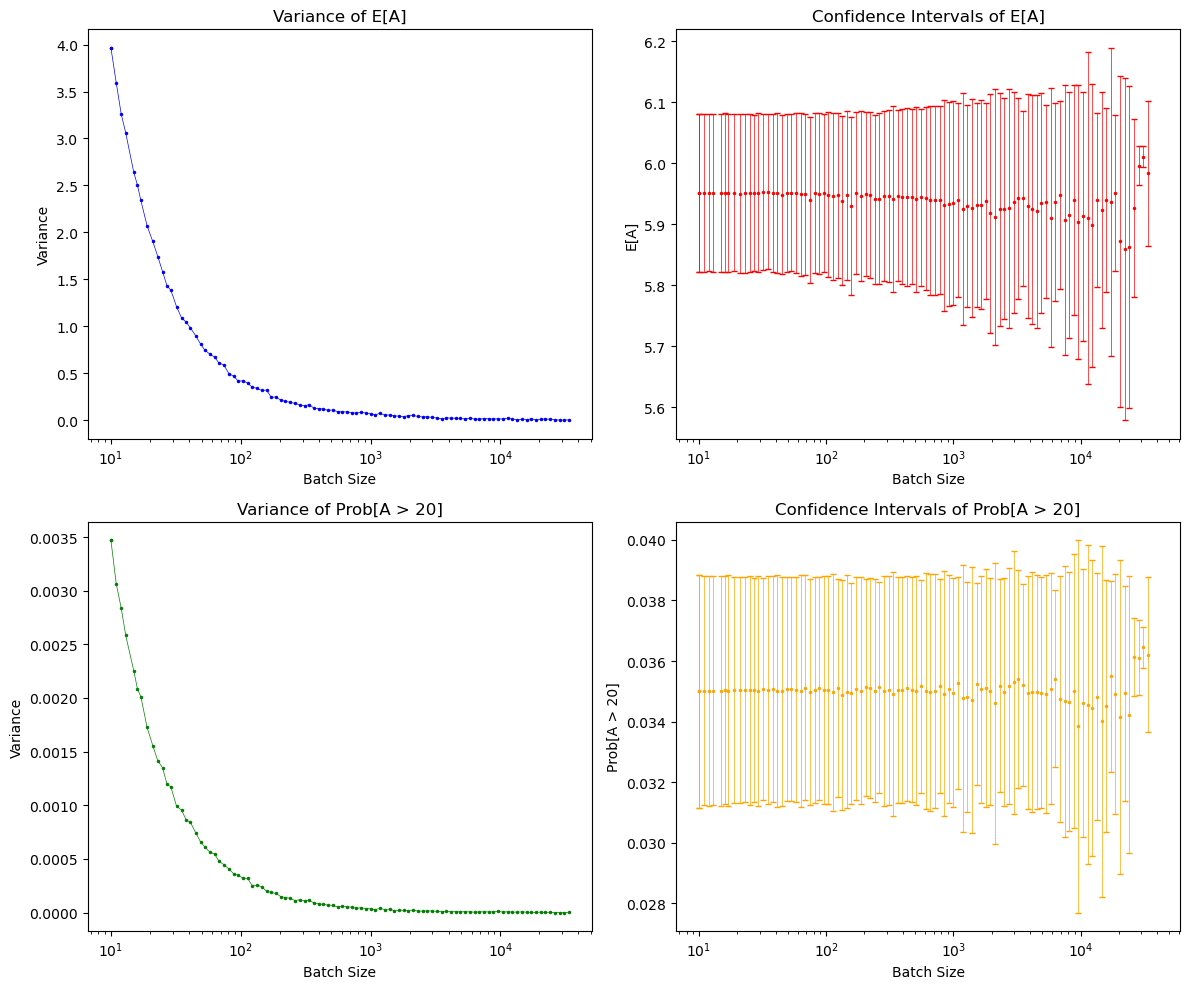

In [26]:
# question d
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_estimates(on_periods, batch_size):
    if batch_size:
        batch_means_EA = [np.mean(on_periods[i:i + batch_size]) for i in range(0, len(on_periods), batch_size)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods[i:i + batch_size]]) for i in range(0, len(on_periods), batch_size)]
    else:
        batch_means_EA = [np.mean(on_periods)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods])]

    EA_estimate = np.mean(batch_means_EA)
    Prob_estimate = np.mean(batch_means_Prob)

    variance_EA = np.var(batch_means_EA, ddof=1) if batch_size else np.var(on_periods, ddof=1)
    variance_Prob = np.var(batch_means_Prob, ddof=1) if batch_size else np.var([length > 20 for length in on_periods], ddof=1)

    ci_EA = stats.norm.interval(0.95, loc=EA_estimate, scale=np.sqrt(variance_EA / len(batch_means_EA)))
    ci_Prob = stats.norm.interval(0.95, loc=Prob_estimate, scale=np.sqrt(variance_Prob / len(batch_means_Prob)))

    return EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob

# Parameters for the simulation
num_steps = 1000000
matrix_size = (5, 6)
batch_sizes = [int(x) for x in np.logspace(np.log10(10), np.log10(40000), num=100, endpoint=True)]

# Run simulation and gather data
on_periods = simulate_on_periods(num_steps, matrix_size)

# Data for plotting
batch_sizes_plot = []
variances_EA = []
variances_Prob = []
ci_EA_values = []
ci_Prob_values = []

# Analyze results with different batch sizes
for batch_size in batch_sizes:
    EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob = calculate_estimates(on_periods, batch_size)
    batch_sizes_plot.append(batch_size)
    variances_EA.append(variance_EA)
    variances_Prob.append(variance_Prob)
    ci_EA_values.append(ci_EA)
    ci_Prob_values.append(ci_Prob)

# Plotting

# Adjusting the plot style to make dots and lines smaller
marker_size = 1.5  # Size of the markers
line_width = 0.5   # Width of the lines

plt.figure(figsize=(12, 10))

# Plot for Variance of E[A]
plt.subplot(2, 2, 1)
plt.plot(batch_sizes_plot, variances_EA, marker='o', color='blue', markersize=marker_size, linewidth=line_width)
plt.title('Variance of E[A]')
plt.xlabel('Batch Size')
plt.ylabel('Variance')
plt.xscale('log')


# Plot for Confidence Intervals of E[A]
plt.subplot(2, 2, 2)
plt.errorbar(batch_sizes_plot, [ci[0] for ci in ci_EA_values], yerr=[ci[1] - ci[0] for ci in ci_EA_values], fmt='o', color='red', markersize=marker_size, elinewidth=line_width, capsize=2)
plt.title('Confidence Intervals of E[A]')
plt.xlabel('Batch Size')
plt.ylabel('E[A]')
plt.xscale('log')


# Plot for Variance of Prob[A > 20]
plt.subplot(2, 2, 3)
plt.plot(batch_sizes_plot, variances_Prob, marker='o', color='green', markersize=marker_size, linewidth=line_width)
plt.title('Variance of Prob[A > 20]')
plt.xlabel('Batch Size')
plt.ylabel('Variance')
plt.xscale('log')


# Plot for Confidence Intervals of Prob[A > 20]
plt.subplot(2, 2, 4)
plt.errorbar(batch_sizes_plot, [ci[0] for ci in ci_Prob_values], yerr=[ci[1] - ci[0] for ci in ci_Prob_values], fmt='o', color='orange', markersize=marker_size, elinewidth=line_width, capsize=2)
plt.title('Confidence Intervals of Prob[A > 20]')
plt.xlabel('Batch Size')
plt.ylabel('Prob[A > 20]')
plt.xscale('log')
plt.tight_layout()
plt.show()




Batch Size: 10
Estimated E[A]: 6.037430555555555 with 95% CI: (5.921763128588788, 6.153097982522322)
Estimated Prob[A > 20]: 0.03555555555555556 with 95% CI: (0.03197244145762299, 0.03913866965348813)
Variance for E[A]: 3.761401756062712, Variance for Prob[A > 20]: 0.0036095149830089584

Batch Size: 20
Estimated E[A]: 6.037314814814814 with 95% CI: (5.923377436429784, 6.151252193199844)
Estimated Prob[A > 20]: 0.03555555555555556 with 95% CI: (0.03205711286471378, 0.039053998246397346)
Variance for E[A]: 1.8248619786298357, Variance for Prob[A > 20]: 0.001720470006184292

Batch Size: 30
Estimated E[A]: 6.0375859788359785 with 95% CI: (5.924031360975581, 6.151140596696376)
Estimated Prob[A > 20]: 0.03556216931216931 with 95% CI: (0.031953107066472745, 0.03917123155786587)
Variance for E[A]: 1.2084144753718056, Variance for Prob[A > 20]: 0.001220660984397886

Batch Size: 40
Estimated E[A]: 6.037816764132554 with 95% CI: (5.923014767448319, 6.152618760816789)
Estimated Prob[A > 20]: 0.035

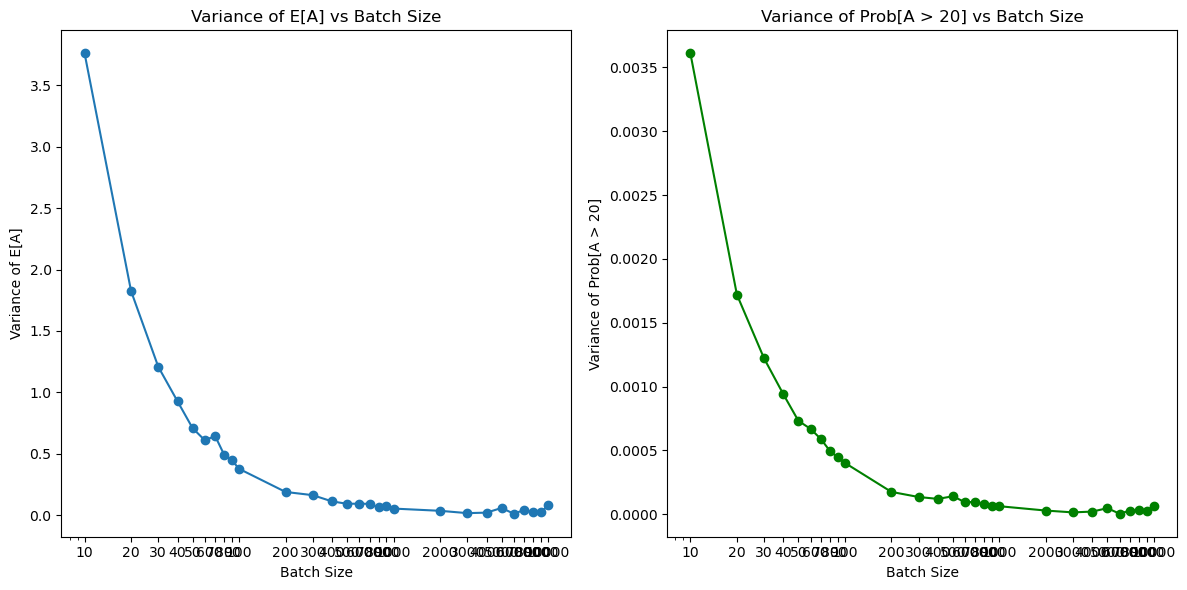

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_estimates(on_periods, batch_size):
    if batch_size:
        batch_means_EA = [np.mean(on_periods[i:i + batch_size]) for i in range(0, len(on_periods), batch_size)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods[i:i + batch_size]]) for i in range(0, len(on_periods), batch_size)]
    else:
        batch_means_EA = [np.mean(on_periods)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods])]

    EA_estimate = np.mean(batch_means_EA)
    Prob_estimate = np.mean(batch_means_Prob)

    variance_EA = np.var(batch_means_EA, ddof=1) if batch_size else np.var(on_periods, ddof=1)
    variance_Prob = np.var(batch_means_Prob, ddof=1) if batch_size else np.var([length > 20 for length in on_periods], ddof=1)

    ci_EA = stats.norm.interval(0.95, loc=EA_estimate, scale=np.sqrt(variance_EA / len(batch_means_EA)))
    ci_Prob = stats.norm.interval(0.95, loc=Prob_estimate, scale=np.sqrt(variance_Prob / len(batch_means_Prob)))

    return EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob

# Parameters for the simulation
num_steps = 300000
matrix_size = (5, 6)
batch_sizes = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900, 1000, 2000, 3000, 4000, 5000,6000,7000,8000,9000,10000] 
# Run simulation and gather data
on_periods = simulate_on_periods(num_steps, matrix_size)

# Prepare data for plotting
batch_sizes_plot = []
variances_EA = []
variances_Prob = []

# Analyze results with different batch sizes
for batch_size in batch_sizes:
    EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob = calculate_estimates(on_periods, batch_size)
    print(f"Batch Size: {batch_size if batch_size else 'No Batching'}")
    print(f"Estimated E[A]: {EA_estimate} with 95% CI: {ci_EA}")
    print(f"Estimated Prob[A > 20]: {Prob_estimate} with 95% CI: {ci_Prob}")
    print(f"Variance for E[A]: {variance_EA}, Variance for Prob[A > 20]: {variance_Prob}\n")

    # Prepare data for plotting
    batch_sizes_plot.append(batch_size if batch_size else 0)  # Use 0 to represent 'No Batching'
    variances_EA.append(variance_EA)
    variances_Prob.append(variance_Prob)

# Plotting
plt.figure(figsize=(12, 6))

# Plot for E[A]
plt.subplot(1, 2, 1)
plt.plot(batch_sizes_plot, variances_EA, marker='o')
plt.title('Variance of E[A] vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Variance of E[A]')
plt.xscale('log')
plt.xticks(batch_sizes_plot, labels=[str(bs) if bs else 'No Batching' for bs in batch_sizes_plot])

# Plot for Prob[A > 20]
plt.subplot(1, 2, 2)
plt.plot(batch_sizes_plot, variances_Prob, marker='o', color='green')
plt.title('Variance of Prob[A > 20] vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Variance of Prob[A > 20]')
plt.xscale('log')
plt.xticks(batch_sizes_plot, labels=[str(bs) if bs else 'No Batching' for bs in batch_sizes_plot])

plt.tight_layout()
plt.show()


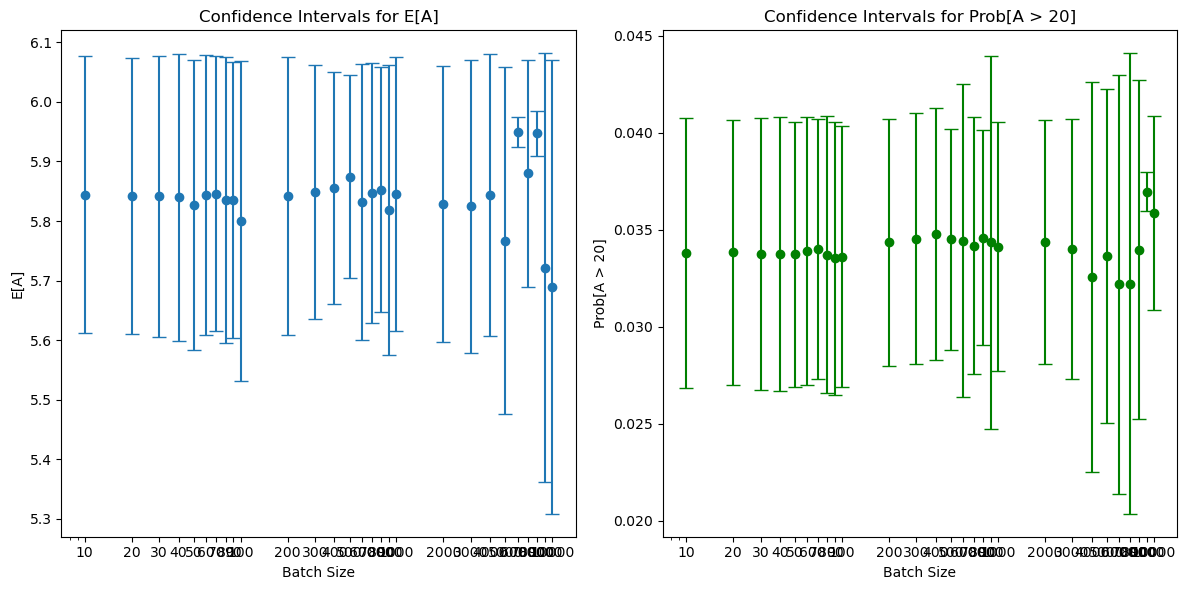

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def calculate_estimates(on_periods, batch_size):
    if batch_size:
        batch_means_EA = [np.mean(on_periods[i:i + batch_size]) for i in range(0, len(on_periods), batch_size)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods[i:i + batch_size]]) for i in range(0, len(on_periods), batch_size)]
    else:
        batch_means_EA = [np.mean(on_periods)]
        batch_means_Prob = [np.mean([length > 20 for length in on_periods])]

    EA_estimate = np.mean(batch_means_EA)
    Prob_estimate = np.mean(batch_means_Prob)

    variance_EA = np.var(batch_means_EA, ddof=1) if batch_size else np.var(on_periods, ddof=1)
    variance_Prob = np.var(batch_means_Prob, ddof=1) if batch_size else np.var([length > 20 for length in on_periods], ddof=1)

    ci_EA = stats.norm.interval(0.95, loc=EA_estimate, scale=np.sqrt(variance_EA / len(batch_means_EA)))
    ci_Prob = stats.norm.interval(0.95, loc=Prob_estimate, scale=np.sqrt(variance_Prob / len(batch_means_Prob)))

    return EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob

# Parameters for the simulation
num_steps = 300000
matrix_size = (5, 6)
batch_sizes = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900, 1000, 2000, 3000, 4000, 5000,6000,7000,8000,9000,10000] 

# Run simulation and gather data (assuming simulate_on_periods is defined)
on_periods = simulate_on_periods(num_steps, matrix_size)

# Prepare data for plotting
batch_sizes_plot = []
ci_EA_values = []
ci_Prob_values = []

# Analyze results with different batch sizes
for batch_size in batch_sizes:
    EA_estimate, Prob_estimate, variance_EA, variance_Prob, ci_EA, ci_Prob = calculate_estimates(on_periods, batch_size)
    batch_sizes_plot.append(batch_size if batch_size else 0)  # Use 0 to represent 'No Batching'
    ci_EA_values.append(ci_EA)
    ci_Prob_values.append(ci_Prob)

# Plotting confidence intervals
plt.figure(figsize=(12, 6))

# Plot for E[A]
plt.subplot(1, 2, 1)
lower_ci_EA, upper_ci_EA = zip(*ci_EA_values)
plt.errorbar(batch_sizes_plot, [x[0] for x in ci_EA_values], yerr=[upper - lower for lower, upper in zip(lower_ci_EA, upper_ci_EA)], fmt='o', capsize=5)
plt.title('Confidence Intervals for E[A]')
plt.xlabel('Batch Size')
plt.ylabel('E[A]')
plt.xscale('log')
plt.xticks(batch_sizes_plot, labels=[str(bs) if bs else 'No Batching' for bs in batch_sizes_plot])

# Plot for Prob[A > 20]
plt.subplot(1, 2, 2)
lower_ci_Prob, upper_ci_Prob = zip(*ci_Prob_values)
plt.errorbar(batch_sizes_plot, [x[0] for x in ci_Prob_values], yerr=[upper - lower for lower, upper in zip(lower_ci_Prob, upper_ci_Prob)], fmt='o', color='green', capsize=5)
plt.title('Confidence Intervals for Prob[A > 20]')
plt.xlabel('Batch Size')
plt.ylabel('Prob[A > 20]')
plt.xscale('log')
plt.xticks(batch_sizes_plot, labels=[str(bs) if bs else 'No Batching' for bs in batch_sizes_plot])

plt.tight_layout()
plt.show()


In [21]:
# question f
# Simulation parameters
num_steps = 100000
matrix_size = (5, 6)

# Run simulation
on_periods = simulate_on_periods(num_steps, matrix_size)

# Analyze consecutive ON-period lengths
if len(on_periods) > 1:
    An = on_periods[:-1]  # Lengths of nth ON-period
    An_plus_1 = on_periods[1:]  # Lengths of (n+1)th ON-period

    # Calculate covariance
    covariance = np.cov(An, An_plus_1)[0, 1]

    print(f"Covariance between consecutive ON-periods: {covariance}")

    # Check for independence (Covariance close to zero)
    if np.isclose(covariance, 0, atol=1e-3):
        print("The sequence An may form a Markov chain (based on covariance analysis).")
    else:
        print("The sequence An may not form a Markov chain (based on covariance analysis).")
else:
    print("Not enough data for analysis.")


Covariance between consecutive ON-periods: 0.7115998271407452
The sequence An may not form a Markov chain (based on covariance analysis).
